In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", 200)
import warnings
warnings.filterwarnings('ignore')

## Leitura dos datasets e rótulos

In [2]:
df = pd.read_csv('./testbed/data/malicious_dataset.csv') # dataset malicioso
attack_classes = pd.read_csv("./testbed/data/attack_labels_sbseg.csv") # rótulos dos ataques por ip_src
normal = pd.read_csv('./mawilab/data/normal_dataset.csv') # dataset normal

### Rótulos de ataques

In [3]:
attack_classes['label'].unique()

array(['nmap_tcp_syn', 'nmap_tcp_conn', 'nmap_tcp_null', 'nmap_tcp_xmas',
       'nmap_tcp_fin', 'nmap_tcp_ack', 'nmap_tcp_window',
       'nmap_tcp_maimon', 'unicornscan_tcp_syn', 'unicornscan_tcp_conn',
       'unicornscan_tcp_null', 'unicornscan_tcp_xmas',
       'unicornscan_tcp_fxmas', 'unicornscan_tcp_fin',
       'unicornscan_tcp_ack', 'hping_tcp_syn', 'hping_tcp_null',
       'hping_tcp_xmas', 'hping_tcp_fin', 'hping_tcp_ack', 'zmap_tcp_syn',
       'masscan_tcp_syn'], dtype=object)

### Criação do dataset malicioso com os rótulos definidos pelo *ip_src*

In [4]:
df_labeled = df.merge(attack_classes, how='inner', left_on='ip.src', right_on='ip')
df_labeled.drop(['ip'], axis=1, inplace=True)
df_labeled.head(2)

,frame_info.encap_type,frame_info.time,frame_info.time_epoch,frame_info.number,frame_info.len,frame_info.cap_len,eth.type,ip.version,ip.hdr_len,ip.tos,ip.id,ip.flags,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.checksum,ip.src,ip.dst,ip.len,ip.dsfield,tcp.srcport,tcp.dstport,tcp.seq,tcp.ack,tcp.len,tcp.hdr_len,tcp.flags,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val,label
0,1,"Dec 31, 1969 21:03:41.953641000 -03",221.953641,20,58,58,0x00000800,4,20,NaN,0x0000b2c5,0x00000000,0,0,0,0,46,6,0x000019e0,172.16.0.3,10.10.10.10,44,0x00000000,62218,8888,0,0,0,24,0x00000002,0,1,0,0,0,0,0,1024,0x00005cb1,0,1460.0,nmap_tcp_syn
1,1,"Dec 31, 1969 21:03:41.953762000 -03",221.953762,21,58,58,0x00000800,4,20,NaN,0x0000d3a4,0x00000000,0,0,0,0,37,6,0x00000201,172.16.0.3,10.10.10.10,44,0x00000000,62218,587,0,0,0,24,0x00000002,0,1,0,0,0,0,0,1024,0x00007d1e,0,1460.0,nmap_tcp_syn


In [5]:
normal['label'] = "normal" # criação da coluna label no dataset normal com rótulo "normal"

## Comparação dataset _normal_ e _malicioso_
> Verifica se os dois datasets possuem as mesmas colunas/atributos e calcula o % de dados legítimos e maliciosos

In [6]:
if (df_labeled.columns == normal.columns).all():
    examples_malicious = df_labeled.shape[0]
    examples_legitim = normal.shape[0]
    total = examples_malicious+examples_legitim
    print('Total examples of {0} with {1:0.2f} of malicious and {2:0.2f} legitim packets'.format(total, examples_malicious/total, examples_legitim/total))

Total examples of 125467 with 0.18 of malicious and 0.82 legitim packets


## Pré-processamento
> Necessário conversão dos atributos que são extraídos do `pcap` como hexadecimal
> Preenchido os campos que possuem valores nulos (NaN) por zero

In [7]:
fields = ['eth.type', 'ip.id', 'ip.flags', 'ip.checksum', 'ip.dsfield', 'tcp.flags', 'tcp.checksum']

for field in fields:
    df_labeled[field] = df_labeled[field].apply(lambda x: int(str(x), 16))
    

In [8]:
normal = normal.fillna(0)
for field in fields:
    normal[field] = normal[field].apply(lambda x: int(str(x), 16))

### Criação do dataset com todos os pacotes normais e maliciosos

In [205]:
full_data = pd.concat([normal, df_labeled])

### Atributos não aplicáveis nesse trabalho

> Remoção dos atributos da camada de enlace (link) - layer 2:
> - frame_info.time
> - frame_info.encap_type
> - frame_info.time_epoch
> - frame_info.number
> - frame_info.len
> - frame_info.cap_len
> - eth.type

> Remoção de atributos redudantes ou invariáveis
> - ip.version - trata-se de IPv4
> - ip.src
> - ip.dst
> - ip.flags
> - tcp.flags - utiliza-se as flags separadamente

In [206]:
full_data.drop(columns=['frame_info.time', 'frame_info.encap_type', 'frame_info.time_epoch', 'frame_info.number', 
                        'frame_info.len', 'frame_info.cap_len', 'eth.type', 'ip.src', 'ip.dst',
                        'ip.version', 'ip.flags', 'tcp.flags'], axis=1, inplace=True)

## Análise Exploratória dos Dados

In [207]:
relevant_columns = list((full_data.var() > 0).index) # apenas as colunas com Variância maior que 0

### Análise univariada dos atributos (boxplot)

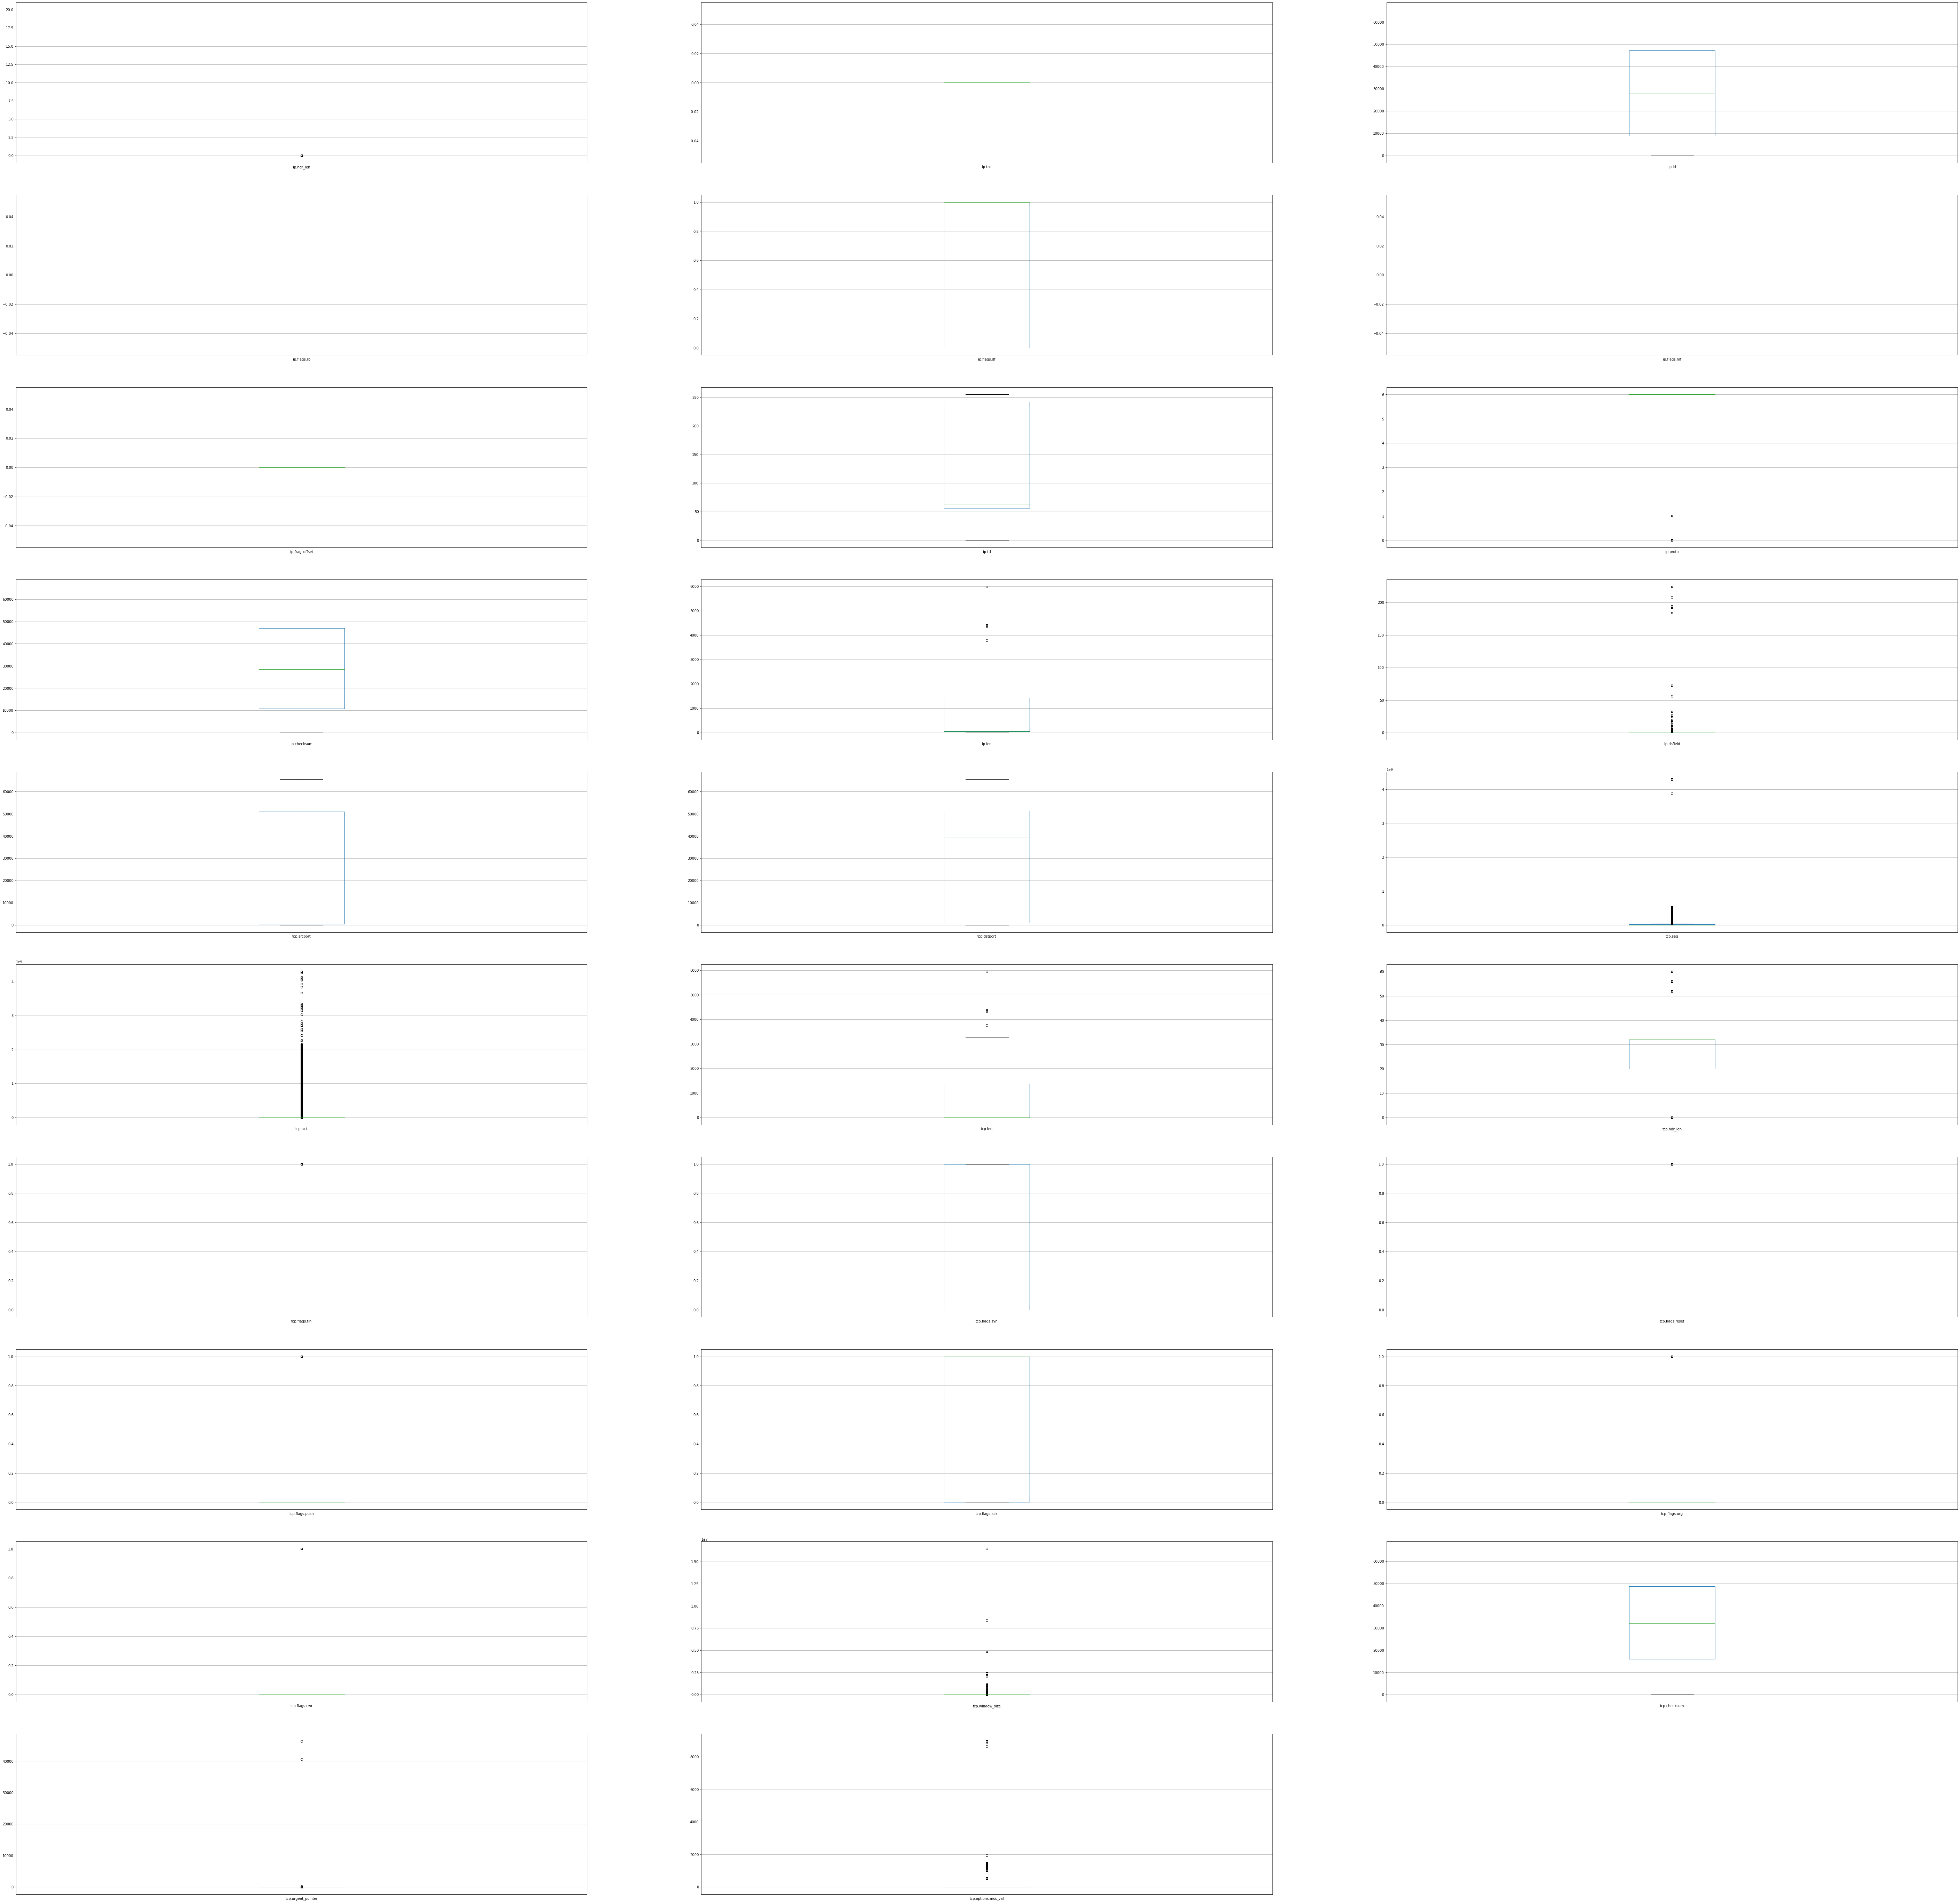

In [208]:
colunas = 3
linhas = int(len(relevant_columns)/colunas)+1

plt.figure(figsize = [100, 100])

i = 1
for column in relevant_columns:
    plt.subplot(linhas, colunas, i)
    full_data.boxplot([column]);
    i += 1

### Análise bivariada - Correlação linear (threshold de 0.5)

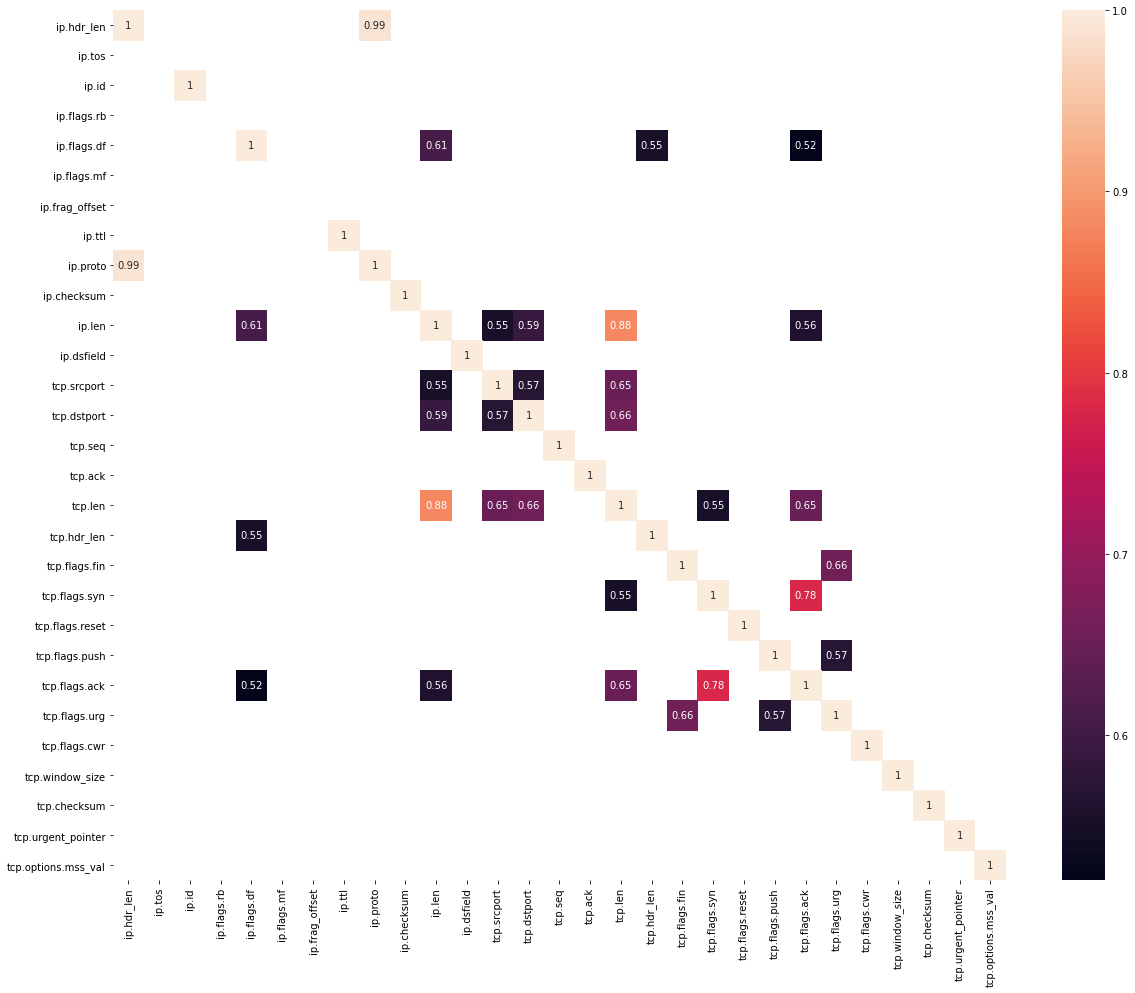

In [209]:
import seaborn as sns
high_corr = full_data.corr().abs().round(2)
high_corr_var = high_corr[high_corr>0.5]
plt.figure(figsize = (20,16))
sns.heatmap(high_corr_var, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

## Aprendizado de Máquina - Classificação Binária _(scan x normal)_

In [210]:
full_data['label'].value_counts()

normal                   103094
zmap_tcp_syn               1250
unicornscan_tcp_conn       1026
unicornscan_tcp_syn        1017
unicornscan_tcp_fin        1014
unicornscan_tcp_xmas       1014
unicornscan_tcp_null       1014
unicornscan_tcp_ack        1014
unicornscan_tcp_fxmas      1014
masscan_tcp_syn            1003
nmap_tcp_conn              1002
nmap_tcp_null              1001
nmap_tcp_syn               1001
hping_tcp_syn              1001
nmap_tcp_xmas              1001
nmap_tcp_fin               1001
hping_tcp_fin              1000
nmap_tcp_maimon            1000
nmap_tcp_ack               1000
hping_tcp_ack              1000
hping_tcp_null             1000
hping_tcp_xmas             1000
nmap_tcp_window            1000
Name: label, dtype: int64

In [211]:
full_data.label[full_data.label == "normal"] = 0 # converte os labels de normal por 0
full_data.label[full_data.label != 0] = 1 # converte os labels de scan por 1
full_data['label'].value_counts()

0    103094
1     22373
Name: label, dtype: int64

In [212]:
full_data.shape

(125467, 30)

In [213]:
full_data.drop(columns=["ip.checksum", "tcp.checksum", "tcp.dstport"], axis=1, inplace=True)

In [214]:
full_data

,ip.hdr_len,ip.tos,ip.id,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.len,ip.dsfield,tcp.srcport,tcp.seq,tcp.ack,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer,tcp.options.mss_val,label
0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,443.0,1.0,1.0,1400.0,20.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,131.0,0.0,0.0,0
1,20.0,0.0,46834,0.0,0.0,0.0,0.0,247.0,6.0,40.0,0,53026.0,0.0,0.0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,0.0,0
2,20.0,0.0,41659,0.0,0.0,0.0,0.0,251.0,1.0,56.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,20.0,0.0,3793,0.0,1.0,0.0,0.0,56.0,6.0,537.0,8,443.0,1.0,1.0,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,252.0,0.0,0.0,0
4,20.0,0.0,0,0.0,1.0,0.0,0.0,59.0,6.0,80.0,0,59206.0,1.0,1.0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4677.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22368,20.0,NaN,32904,0.0,0.0,0.0,0.0,253.0,6.0,40.0,0,40059.0,0.0,0.0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,NaN,1
22369,20.0,NaN,55978,0.0,0.0,0.0,0.0,253.0,6.0,40.0,0,40059.0,1.0,0.0,0.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1200.0,0.0,NaN,1
22370,20.0,NaN,32903,0.0,0.0,0.0,0.0,253.0,6.0,40.0,0,40059.0,1.0,0.0,0.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1200.0,0.0,NaN,1
22371,20.0,NaN,6985,0.0,0.0,0.0,0.0,253.0,6.0,40.0,0,40059.0,0.0,0.0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,NaN,1


In [215]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

algorithms = {
    "DT" : (DecisionTreeClassifier(), {
        "criterion": ("gini", "entropy"), 
        "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    })
}

full_data = full_data.fillna(0)
X = full_data.drop(columns = ["label"])
y = full_data.label

print(X.shape, y.shape)

(125467, 26) (125467,)


## Grid Search para os parâmetros da Árvore de Decisão

In [216]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17) # Train, Test
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17) # Validation
perf = f1_score # pode ser considerado também o roc_auc_score na classificação binária

score = {}
for algorithm in algorithms.keys():
    score[algorithm] = []

for algorithm, (clf, parameters) in algorithms.items():
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        prep.fit(X.iloc[train])
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        score[algorithm].append(perf(best.predict(prep.transform(X.iloc[test])), y.iloc[test]))

In [217]:
# f1-scores para o melhor conjunto de parâmetros do Grid Search
pd.DataFrame.from_dict(score)

,DT
0,0.999777
1,0.999777
2,1.000000
3,0.999776
4,0.999553
5,1.000000
6,0.999777
7,0.999777
8,0.999777
9,0.999553


## Resultado do Grid Search
> Conjunto de hiper-parâmetros, média e desvio padrão

In [218]:
dados = []
for i in range(0,len(best.cv_results_['params'])):
    print(best.cv_results_['params'][i], best.cv_results_['mean_test_score'][i], 
          best.cv_results_['std_test_score'][i])
    dados.append([best.cv_results_['params'][i]['criterion'], 
                  best.cv_results_['params'][i]['max_depth'], best.cv_results_['mean_test_score'][i]])

{'criterion': 'gini', 'max_depth': 3} 0.7708090447359294 0.0025583389774496974
{'criterion': 'gini', 'max_depth': 4} 0.8562195294442154 0.0018058968135711137
{'criterion': 'gini', 'max_depth': 5} 0.8933584844659014 0.00016816818915734968
{'criterion': 'gini', 'max_depth': 6} 0.913869135199543 0.0003390314777265926
{'criterion': 'gini', 'max_depth': 7} 0.9164224293771217 0.0003511199522022408
{'criterion': 'gini', 'max_depth': 8} 0.9190850445264491 0.0008084689286346631
{'criterion': 'gini', 'max_depth': 9} 0.9854673659844572 0.0008483027953140024
{'criterion': 'gini', 'max_depth': 10} 0.9915284716100202 0.0008523210078345313
{'criterion': 'entropy', 'max_depth': 3} 0.7935496445982785 0.004043307506685735
{'criterion': 'entropy', 'max_depth': 4} 0.9103423587573588 0.001293254788427193
{'criterion': 'entropy', 'max_depth': 5} 0.9874698387115625 0.00040304494099879004
{'criterion': 'entropy', 'max_depth': 6} 0.9955986777414328 0.0002724062361169122
{'criterion': 'entropy', 'max_depth': 7}

In [219]:
gini = {}
entropia = {}
for valores in dados:
    if valores[0] == "gini":
        gini.update({valores[1] : valores[2]})
    else:
        entropia.update({valores[1] : valores[2]})

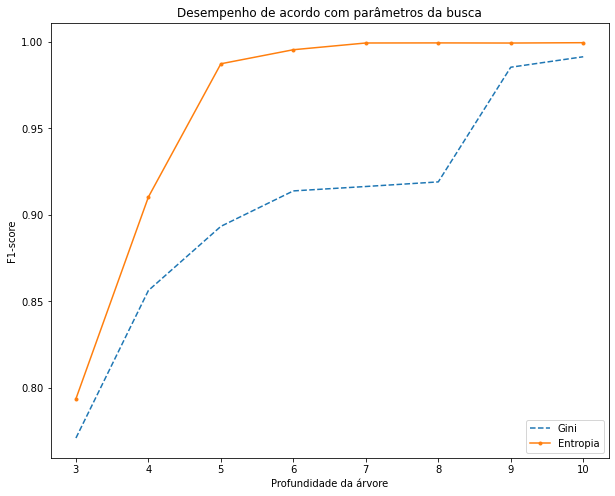

In [220]:
lists1 = sorted(gini.items())
lists2 = sorted(entropia.items())
x_gini, y_gini = zip(*lists1)
x_entropia, y_entropia = zip(*lists2)

plt.figure(figsize=(10,8))

plt.title('Desempenho de acordo com parâmetros da busca')
plt.ylabel('F1-score')
plt.xlabel('Profundidade da árvore')
plt.plot(x_gini, y_gini, '--', label='Gini')
plt.plot(x_entropia, y_entropia, '.-', label='Entropia')
plt.legend(loc="lower right");

## Avaliação da importância das features

In [228]:
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(criterion='entropy', max_depth=6)
cross_val_score(clf, X, y, cv=10)

array([0.87463139, 0.99744959, 0.95967163, 0.9988842 , 0.99593528,
       0.9991233 , 0.91711166, 0.99928264, 0.91949625, 0.9379085 ])

In [229]:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

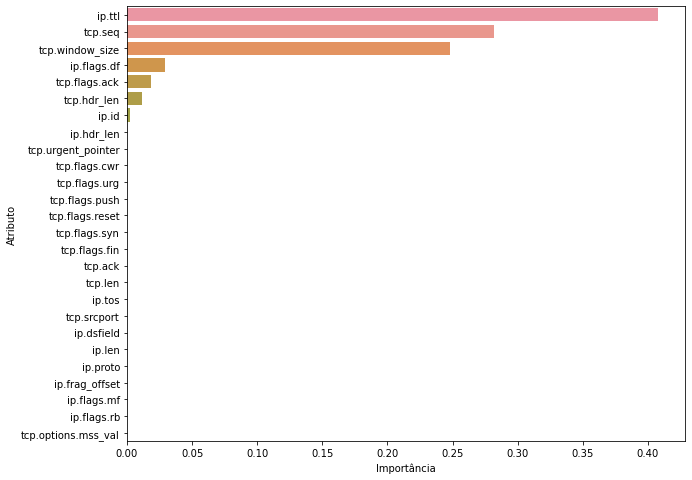

In [230]:
feature_importance = np.array(clf.feature_importances_)
feature_names = np.array(X.columns)

data = {'feature_name': feature_names,
       'feature_importance': feature_importance}

fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

plt.figure(figsize=(10,8))
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_name'])
plt.xlabel('Importância')
plt.ylabel('Atributo');

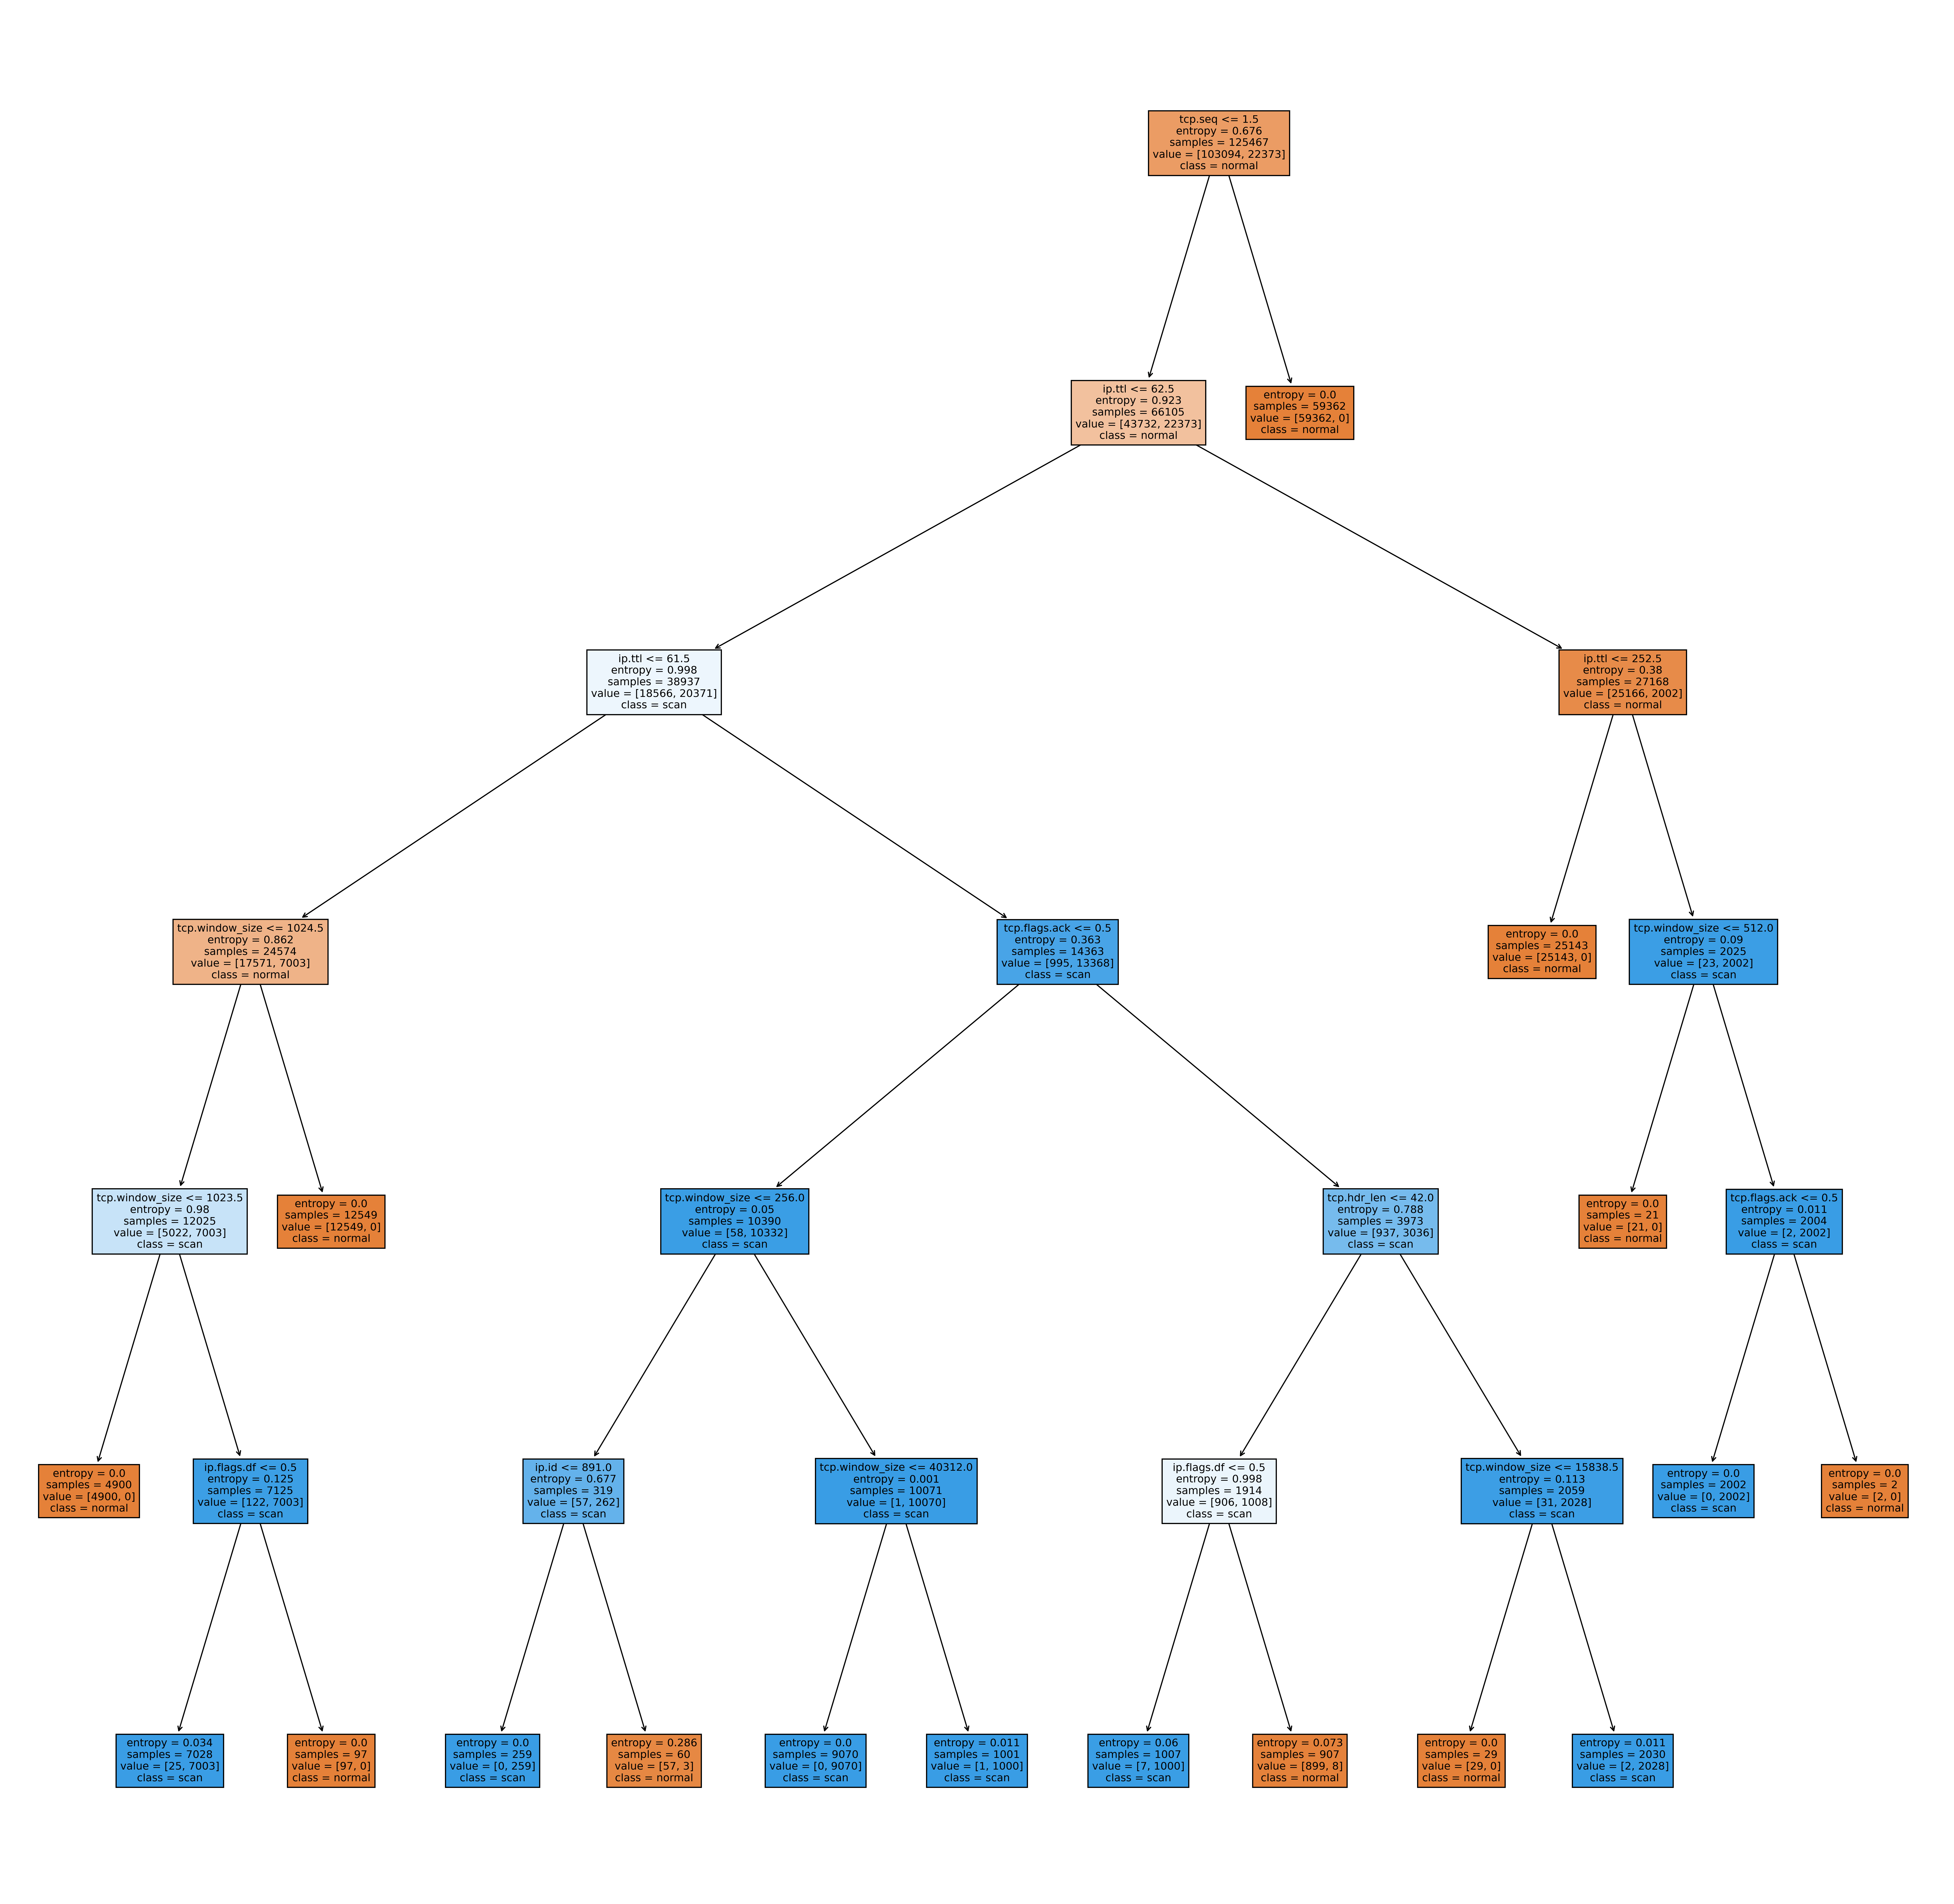

In [231]:
from sklearn import tree

fn=X.columns
cn=['normal', 'scan']
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (30,30), dpi=300)
tree.plot_tree(clf,
               feature_names = fn, 
               class_names=cn,
               filled = True);

# Geração do modelo de inferência para ser embarcado

In [233]:
import emlearn
cmodel = emlearn.convert(clf, method='inline')
cmodel.save(file='scan_detection.h');